Note that this notebook was used in other directory.   
This was to remove duplicate papers

In [ ]:
import datasets
from datasets import load_from_disk

dataset = load_from_disk('../data/paperswithcode/')
dataset

In [ ]:
full_ds = datasets.concatenate_datasets([dataset["train"], dataset["dev"], dataset["test_gt"]])
full_ds

In [ ]:
set(full_ds["area"])

In [ ]:
len(set(map(str.lower, full_ds["title"])))

In [ ]:
from collections import Counter

counter = Counter(map(str.lower, full_ds["title"]))
multiple = [k for k, v in counter.items() if v > 1]

In [ ]:
duplicates = full_ds.filter(lambda x: x["title"].lower() in multiple)

In [ ]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

In [ ]:
idx = argsort(duplicates["title"])
duplicates[idx]["area"]

In [ ]:
for i in range(0, 50, 2):
    if duplicates[idx]["area"][i] != duplicates[idx]["area"][i+1]:
        print(i)
        print(duplicates[idx]["area"][i], duplicates[idx]["area"][i+1])

In [ ]:
duplicates[idx]["title"][14]

In [ ]:
duplicates[idx]["title"][16]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

hist = Counter(full_ds["area"])
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_title("Category Distribution", size="x-large")
ax.set_xlabel("A.I. Subfield", size="x-large")
ax.set_ylabel("Counts", size="x-large")
ax.set_xticklabels(list(hist.keys()), rotation=90, size="large")
sns.barplot(list(hist.keys()), list(hist.values()), ax=ax)

In [ ]:
duplicate_set = set(duplicates["title"])
delete_set = [
    'Decoding visemes: improving machine lipreading',
    'Distributed Online Learning with Multiple Kernels'
]
for d in delete_set:
    duplicate_set.remove(d)

In [ ]:
full_pd = full_ds.to_pandas()
full_pd = full_pd[full_pd.title.map(lambda x: x not in delete_set)]
full_pd = full_pd.sort_values(by=["title", "arxiv_id"]).drop_duplicates(subset=["title"], keep="last")
full_pd.drop(9929, inplace=True)

In [ ]:
processed_ds = datasets.Dataset.from_pandas(full_pd)
processed_ds = processed_ds.remove_columns('__index_level_0__')

In [ ]:
from sklearn.model_selection import train_test_split

train_pp, testdev_pp = train_test_split(processed_ds, train_size=0.9, random_state=42, stratify=processed_ds['area'])

testdev_pp = datasets.Dataset.from_dict(testdev_pp)
dev_pp, test_pp = train_test_split(testdev_pp, test_size=0.5, random_state=42, stratify=testdev_pp['area'])

In [ ]:
train_pp = datasets.Dataset.from_dict(train_pp)
# train_pp.save_to_disk('./data/paperswithcode/train')

dev_pp = datasets.Dataset.from_dict(dev_pp)
# dev_pp.save_to_disk('./data/paperswithcode/dev')

test_pp = datasets.Dataset.from_dict(test_pp)
# test_pp.save_to_disk('./data/paperswithcode/test_gt')

# test_pp = test_pp.remove_columns(['area', 'task_id'])
# test_pp.save_to_disk('./data/test')

In [ ]:
data_dir = "H:/My Drive/school_materials/2021Fall/bayesian_final_project/data/paperswithcode"

In [ ]:
train_pp.save_to_disk(f'{data_dir}/train')
dev_pp.save_to_disk(f'{data_dir}/dev')
test_pp.save_to_disk(f'{data_dir}/test_gt')

In [20]:
import json
import datasets
from collections import Counter

full_dataset = datasets.load_from_disk("../data/tokenized_paperswithcode")
full_dataset = datasets.concatenate_datasets([full_dataset["train"], full_dataset["valid"], full_dataset["test"]])

In [18]:
with open("../assets/area2idx.json", "r") as f:
    area2idx = json.load(f)

In [30]:
idx2area = {v: k for k, v in area2idx.items()}

In [19]:
filtered = full_dataset.filter(lambda x: x["labels"] not in list(map(lambda x: area2idx[x], ["methodology", "audio", "computer-code", 'music'])))

100%|██████████| 53/53 [00:02<00:00, 17.70ba/s]


C:\Users\pha\anaconda3\envs\bnn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pha\anaconda3\envs\bnn\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Category Distribution'}, xlabel='A.I. Subfield', ylabel='Counts'>

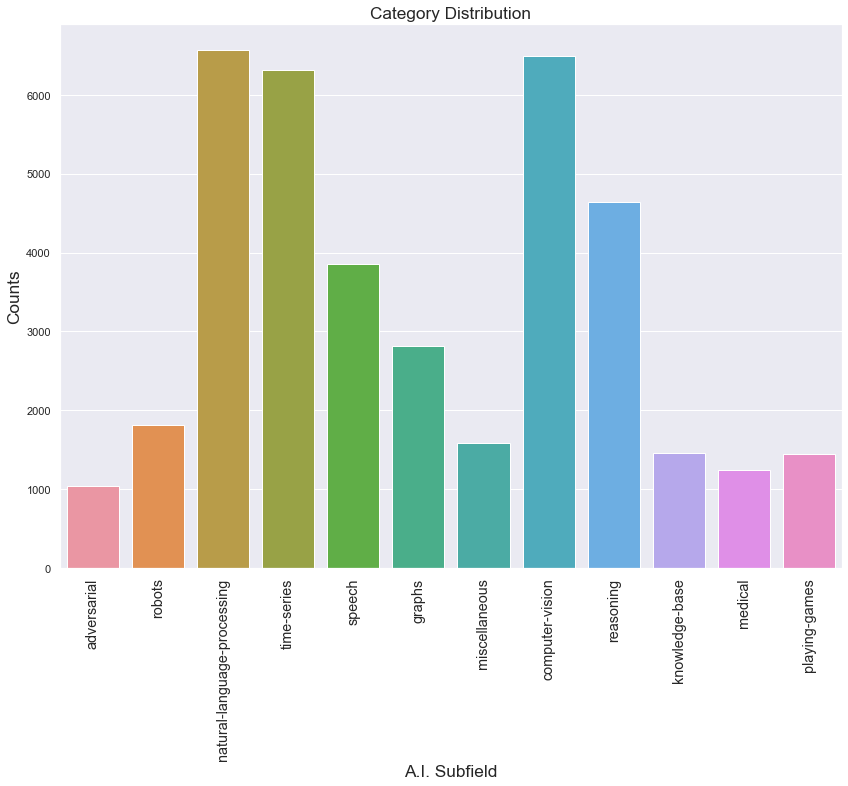

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

hist = Counter(filtered["labels"])
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_title("Category Distribution", size="x-large")
ax.set_xlabel("A.I. Subfield", size="x-large")
ax.set_ylabel("Counts", size="x-large")
ax.set_xticklabels(
    list(map(lambda x: idx2area[x], list(hist.keys()))), rotation=90, size="large"
)
sns.barplot(list(map(lambda x: idx2area[x], list(hist.keys()))), list(hist.values()), ax=ax)

In [37]:
leftover_keys = sorted(map(lambda x: idx2area[x], list(hist.keys())))

In [39]:
balanced_mapper = {area: idx for idx, area in enumerate(leftover_keys)}

In [45]:
def batch_map(example):

    example["labels"] = balanced_mapper[idx2area[example["labels"]]]
    return example

In [47]:
filtered = filtered.map(batch_map)

100%|██████████| 39263/39263 [00:05<00:00, 7207.57ex/s]


In [53]:
from sklearn.model_selection import train_test_split

train_pp, testdev_pp = train_test_split(filtered, train_size=0.9, random_state=42, stratify=filtered['labels'])

testdev_pp = datasets.Dataset.from_dict(testdev_pp)
dev_pp, test_pp = train_test_split(testdev_pp, test_size=0.5, random_state=42, stratify=testdev_pp['labels'])

In [54]:
train_pp = datasets.Dataset.from_dict(train_pp)
train_pp.save_to_disk('../data/paperswithcode_balanced_tokenized/train')

dev_pp = datasets.Dataset.from_dict(dev_pp)
dev_pp.save_to_disk('../data/paperswithcode_balanced_tokenized/valid')

test_pp = datasets.Dataset.from_dict(test_pp)
test_pp.save_to_disk('../data/paperswithcode_balanced_tokenized/test_gt')

# test_pp = test_pp.remove_columns(['area', 'task_id'])
# test_pp.save_to_disk('./data/test')

In [55]:
with open("../data/paperswithcode_balanced_tokenized/area2idx.json", "w") as f:
    json.dump(balanced_mapper, f)